# Teoria Moderna do Portfólio em Python
 _Baseado [nesse artigo do Medium](https://medium.com/turing-talks/teoria-moderna-do-portf%C3%B3lio-em-python-e8bad41ebb8b)_
 
## Introdução
A Teoria de Portfólio de Markowitz, desenvolvida pelo economista Harry Markowitz, é um amplamente utilizado para otimizar a alocação de ativos financeiros em um portfólio. Essa teoria leva em consideração o equilíbrio entre o **retorno esperado** e o **risco** associado a cada ativo, com o objetivo de encontrar a combinação ideal de ativos que ofereça o máximo de retorno para um determinado nível de risco ou o mínimo de risco para um determinado nível de retorno.

Nesse notebook serão desenvolvidos alguns exemplos de montagens de portfólio com base na Teoria de Markowitz.


## Exemplo 1 - Setor de Beleza/Estética

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import yfinance as yf
import turingquant as tq
import plotly.io as pio

In [2]:
#Foram escolhidas 5 empresas do ramo de beleza/estética para compor o portfólio (Estée Lauder Companies Inc. (EL);
#L'Oréal SA (OR.PA); The Procter & Gamble Company (PG); Ulta Beauty, Inc. (ULTA))
tickers = ['EL', 'OR.PA', 'PG', 'ULTA']

In [3]:
df_close = yf.download(tickers, start='2019-01-01', end='2022-12-31')['Close']

[*********************100%***********************]  4 of 4 completed


In [4]:
df_close

EL       OR.PA          PG        ULTA
Date                                                      
2019-01-02  131.940002  199.600006   91.279999  247.970001
2019-01-03  125.680000  197.199997   90.639999  243.360001
2019-01-04  129.919998  200.000000   92.489998  255.029999
2019-01-07  131.500000  197.449997   92.120003  271.000000
2019-01-08  132.729996  198.649994   92.459999  276.000000
...                ...         ...         ...         ...
2022-12-23  241.020004  333.250000  152.619995  456.399994
2022-12-27  248.289993  336.750000  153.949997  464.000000
2022-12-28  246.190002  335.399994  151.960007  463.519989
2022-12-29  249.929993  338.700012  152.589996  464.829987
2022-12-30  248.110001  333.600006  151.559998  469.070007

[1035 rows x 4 columns]

## Passo-a-Passo:

**1. Escolha do Método:** são 3 os métodos possíveis - o que minimiza a volatilidade, o que maximiza o retorno e o que maximiza o sharpe ratio. Esse sharpe ratio pode ser optido pela fórmula $Sharpe$ $Ratio$ $=$ $(Retorno - RiskFree)$ $/$ $Volatilidade$. No modelo de Markowitz do Turing Quant, define-se que risk free = 0 (tudo tem risco), logo $Sharpe$ $Ratio$ $=$ $Retorno$ $/$ $Volatilidade$

**2. Encontro do Melhor Portfólio:** o melhor portfólio será aquele que, feitas todas as combinações de percentuais de valor investido para cada ação, gerar o melhor valor para a métrica em questão (min volatilidade, max retorno ou max sharpe_ratio)

**3. Visualização da Fronteira Eficiente:** feitas todas as possíveis combinações, também é possível plotá-las para entender melhor onde estão as melhores e piores soluções de um modo geral, não apenas A melhor solução

In [5]:
class Markowitz:
    def __init__(self, df_close, num_portfolios = 10000, risk_free = 0):
        self.df = df_close
        self.num_portfolios = num_portfolios
        self.risk_free = risk_free
        self.wallets = self._generate_wallets()
    
    def _generate_wallets(self):
        '''
        Gera carteiras com pesos aleatórios.
        Returns:
            wallets (dict): dicionário contendo os valores 'weights', 'returns', 'vol' e 'sharpe_ratio'
                            de todos os portfólios gerados 
        '''
        # vetores de dados
        portfolio_weights = []
        portfolio_exp_returns = []
        portfolio_vol = []
        portfolio_sharpe = []
        
        # retorno simples 
        r = self.df.pct_change()
        mean_returns = r.mean() * 252
        
        # matriz de covariância 
        covariance = np.cov(r[1:].T)

        for i in range(self.num_portfolios):
            # gerando pesos aleatórios
            k = np.random.rand(len(self.df.columns))
            w = k / sum (k) # normaliza o vetor 

            # retorno
            R = np.dot(mean_returns, w)

            # risco
            vol = np.sqrt(np.dot(w.T, np.dot(covariance, w))) * np.sqrt(252)

            # sharpe ratio
            sharpe = (R - self.risk_free)/vol

            portfolio_weights.append(w)
            portfolio_exp_returns.append(R)
            portfolio_vol.append(vol)
            portfolio_sharpe.append(sharpe)

        # métricas (colunas) de cada portfólio (linhas)
        metrics = pd.DataFrame({
            'returns': portfolio_exp_returns,
            'vol': portfolio_vol,
            'sharpe': portfolio_sharpe
        })

        # pesos de cada ativo (colunas) por portfólio (linhas)        
        weights = pd.DataFrame(portfolio_weights, columns=self.df.columns)

        # carteira = métricas + colunas com o peso de cada ativo
        wallets = pd.concat([metrics, weights], axis=1)
    
        return wallets
    
    def plot_efficient_frontier(self, method = 'sharpe_ratio'):
        '''
        Plota gráfico com a fronteira eficiente dos portfólios gerados. 
        
        Args: 
            method (string): Método utilizado para indicar o melhor portfólio
                            'sharpe_ratio' - Portfólio com melhor Sharpe ratio
                            'volatility' - Portfólio com menor volatilidade
                            'return' - Portfólio com maior retorno
        '''

        vol = self.wallets['vol']
        returns = self.wallets['returns']
        sharpe = self.wallets['sharpe']
        
        if method == 'sharpe_ratio':            
            best_port_idx = np.array(sharpe).argmax()

        elif method == 'volatility':            
            best_port_idx = np.array(vol).argmin()

        elif method == 'return':             
            best_port_idx = np.array(returns).argmax()

        else:
            raise ValueError(
                f"method espera 'sharpe_ratio', 'volatility' ou 'return', não '{method}'"
            )

        y_axis = returns[best_port_idx]
        X_axis = vol[best_port_idx]

        # Plota todos os portfólios
        fig = px.scatter(
            self.wallets,
            x='vol',
            y='returns',
            hover_data=self.df.columns,
            color='sharpe'
        )

        # Customizações gerais do gráfico
        fig.update_layout(
            width=600, height=600,
            margin=dict(l=10, r=10, t=50, b=10),
            title='Efficient Frontier',
            xaxis_title="Volatility",
            yaxis_title="Returns",
        )

        # Exibe o ponto do melhor portfólio em vermelho
        fig.update_traces(
            marker=dict(size=9, opacity=0.6),
            selectedpoints=[best_port_idx],
            selected=dict(marker=dict(color='black', opacity=1))
        )

        fig.show()
        
        # funçao best_portfolio
    def best_portfolio(self, method = 'sharpe_ratio'):
                
        vol = self.wallets['vol']
        returns = self.wallets['returns']
        sharpe = self.wallets['sharpe']
        weights = self.wallets.iloc[:, 3:]
            
        if method == 'sharpe_ratio':
                best_port_idx = np.array(sharpe).argmax()

        elif method == 'volatility':
                best_port_idx = np.array(vol).argmin()

        elif method == 'return':
                best_port_idx = np.array(returns).argmax()

        else:
            raise ValueError(
                f"method espera 'sharpe_ratio', 'volatility' ou 'return', não '{method}'"
            )

        return weights.iloc[best_port_idx]
        

In [6]:
markowitz = Markowitz(df_close)

Note que assim que criamos um obeto da classe Markowitz, chamamos o método _generate_wallets para gerar 10000 carteiras com pesos aleatórios, e calcular o sharpe, volatilidade e retorno esperado (média ponderada dos retornos ateriores) de cada uma. Esses dados são guardados como atributo do objeto, e serão acessados por outros métodos como o plot_efficient_frontier. Ou seja, a quanto mais carteiras geradas, maior a chance de se aproximar do que seria uma carteira com os pesos ótimos.

In [7]:
fronteira = markowitz.plot_efficient_frontier(method='sharpe_ratio')

                        PONTO DO MELHOR PORTFÓLIO EM PRETO

### Encontrando os melhores pesos para o portfólio

O peso de um ativo em uma carteira representa uma porcentagem do valor total dos investimentos. Com os pesos de um portfólio, pode-se ter uma visão holística de como está disposta sua composição, sendo fácil de visualizar os ativos que influem mais ou menos na carteira. 

Utilizando a função **best_portfolio**, podemos encontrar os pesos do melhor portfólio formado pelas empresas de beleza em questão ('EL', 'OR.PA', 'PG', 'ULTA'). Vale ressaltar que podemos indicar três tipos métodos para a análise: 
- **sharpe_ratio**: portfólio com o melhor *sharpe ratio*;
- **volatility**: portfólio com a menor volatilidade;
- **return**: portfólio com o maior retorno;

Nesse caso, estamos utilizando o método de melhor *sharpe ratio*. 

In [8]:
melhor_portfolio = Markowitz.best_portfolio(markowitz, method = 'sharpe_ratio')
print(melhor_portfolio)

EL       0.086230
OR.PA    0.305310
PG       0.445702
ULTA     0.162757
Name: 1334, dtype: float64


A função resulta nos valores: 

|  ativo|  peso |
|-------|-------|
|   EL  |   0.063224    |
| OR.PA |   0.321405    |
|   PG  |   0.421405    |
|  ULTA |   0.160519    |

Eles espelham que o portfólio que maximiza o *sharpe ratio* é composto majoritariamente por ativos da 'OR.PA' e da 'PG', que juntos somam mais de 50% dos pesos da carteira. Além disso, o ativo EL tem uma participação notavelmente menor do que a dos demais ativos (cerca de 6%), o que pode estar associado a fatores como uma possível volatilidade muito alta ou até uma eventual correlação do EL com outros ativos que compõem a carteira.

**Observações:**
1. Nota-se que, dentro do período analisado (2019-2022), as diferentes combinações apresentam retornos muito próximos (quase todos na faixa entre 0.16 e 0.24), enquanto a volatilidade tem uma variação muito maior (0.2 até 0.4)
2. Nesse sentido, usando o modelo do sharpe ratio, o melhor portfólio foi uma combinação que preferenciou a volatilidade ao retorno. Em outras palavras, ainda que tenha tido um retorno abaixo da média, foi a melhor solução devido à baixíssima volatilidade
3. No exemplo acima, o melhor portfólio foi um que se baseou principalmente na Procter & Gamble e na L'Oréal, mas ainda contou com participações significativas (>5%) dos outros dois ativos, o que pode ter contribuído para a baixa volatilidade

## Exemplo 2 - Big Techs (Sharpe Ratio pode ser ruim?)

In [9]:
#Foram selecionadas as 4 big techs: Apple, Amazon, Google e Microsoft
tickers_2 = ['AAPL', 'GOOGL', 'MSFT', 'AMZN']
df_close_2 = yf.download(tickers_2, start='2022-01-01', end='2022-12-31')['Close']

[*********************100%***********************]  4 of 4 completed


In [10]:
markowitz_2 = Markowitz(df_close_2)
fronteira_2 = markowitz_2.plot_efficient_frontier(method='sharpe_ratio')

**Observações:**
1. Nesse caso, os retornos são negativo. Com isso, pela fórmula $Sharpe$ $Ratio$ $=$ $Retorno$ $/$ $Volatilidade$, uma volatilidade maior acaba por gerar um sharpe ratio artificialmente maior, levando a conclusões equivocadas. 
2. Por isso, no exemplo acima, a "melhor solução" apresenta maior volatilidade e retornos mais negativos (menores, portanto) que outras soluções, mostrando a problemática de usar esse tipo de método para retornos negativos

# Markowitz - Backtesting

### Premissas

- Capital inicial de R$100.000,00
- Rebalanceamento a cada 3 meses de acordo com a estratégia de Markowitz
- Simular investimentos de 01/01/2021 até 01/07-2023
- Sem custo de rebalanceamento
- A cada rebalanceamento considerar os dados dos últimos 5 anos
- Ativos:
    - Bancos:  ITUB4.SA, SANB4.SA, BBAS3.SA, BBDC4.SA
    - Energia: TRPL4.SA, EGIE3.SA, AESB3.SA
    - Saneamento: SAPR11.SA, SBSP3.SA, CSMG3.SA

### Algoritmo

1. Gerar datas de rebalanceamento
1. Para cada data de rebalanceamento
    1. Calcular a melhor carteira de acordo com Markowitz utilizando os dados dos últimos PW anos, armazenando-a
    1. Simular retorno da carteira calculada até a próxima data de rebalanceamento, armazenando-a


Parâmetros
* PW: Past Window, período de tempo no passado que será utilizado para calcular o peso da carteira (ex: 5 anos)
* RP: Rebalancing Period, período em que será feito o rebalanceamento (ex: 3 Meses)
* Tickers: Ativos que irão compor a carteira
* Start_date e End_date


### Preliminares

#### Utilitários

In [11]:
import time
import pandas as pd
from typing import List
import yfinance as yf
import turingquant.metrics as tq
from datetime import datetime, timedelta


# Decorador para cronometrar tempo de execução
# Não deve ser utilizado em funções recursivas
def timer(func):
    def wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        execution_time = end_time - start_time
        print(f"Function '{func.__name__}' took {execution_time:.6f} seconds to execute.")
        return result
    return wrapper

class Params:
    def __init__(self, tickers: List[str], start_date: str, end_date: str) -> None:
        self.df = yf.download(tickers, start=start_date, end=end_date)
        self.df.index = pd.to_datetime(self.df.index)
        self.tickers : pd.DataFrame = tickers
        self.start_date : pd.DataFrame = start_date
        self.end_date : pd.DataFrame = end_date
        self.adj_close : pd.DataFrame = self.df['Adj Close']
        self.close : pd.DataFrame = self.df['Close']
        self.high : pd.DataFrame = self.df['High']
        self.low : pd.DataFrame = self.df['Low']
        self.open : pd.DataFrame = self.df['Open']
        self.volume : pd.DataFrame = self.df['Volume']
        self.returns_daily = self.adj_close.pct_change().fillna(0)  # Retornos diários
        self.returns_monthly = self.adj_close.pct_change(20).fillna(0).resample('BM').last().ffill()  # Retornos mensais

#### Backtesting

In [102]:
import pandas as pd
import seaborn as sns

class MarkowitzBacktesting:
    """
    Classe que implementa backtesting utilizando a estratégia de Markowitz

    Parâmetros
    ----------

    tickers: List[str]
        lista de tickers dos ativos que compõem a carteira a ser simulada
    start_date: str
        string no formato %Y-%m-%d que representa o início do período simulado Ex: '2011-01-23'
    end_date: str
        string no formato %Y-%m-%d que representa o final do período simulado. Ex: '2021-12-29'
    past_window: timedelta
        período de tempo no passado que será levado em consideração para calcular os pesos dos
        ativos na carteira a cada rebalanceamento. Exemplo: timedelta(days=5 * 365)
    rebalancing_period: pd.DateOffset
        período do rebalanceamento. Ex: pd.DateOffset(months=3) significa rebalancear a cada 3 meses
    num_portfolios: int
        quantidade de portfolios aleatórios gerados para simulação de Markowitz. Quanto maior esse número,
        mais próximo do portfolio "ideal", porém demora mais para processar
    risk_free: int
        não faço ideia
    method: string
        pode ser uma das três: 'sharpe_ratio', 'volatility' ou 'return'. Tem algo a ver com como
        Markowitz rebalanceia os pesos 
    """
    
    def __init__(
        self,
        tickers: List[str],
        start_date: str,
        end_date: str,
        past_window: timedelta,
        rebalancing_period: pd.DateOffset,
        num_portfolios = 10000, 
        risk_free = 0,
        method='sharpe_ratio'
    ):
        self.rebalancing_period = rebalancing_period
        self.start_date = start_date
        self.end_date = end_date
        self.tickers = tickers
        self.past_window = past_window
        self.num_portfolios = num_portfolios
        self.risk_free = risk_free
        self.method = method

        self._portfolio = []
        self._compute_rebalancing_dates()
        self._download_data()

    def _compute_rebalancing_dates(self):
        """
        Calcula as datas em que será necessário realizar o balanceamento
        """
        self.rebalancing_dates = pd.date_range(
            start=self.start_date, end=self.end_date, freq=self.rebalancing_period
        )

    def _download_data(self):
        """
        Baixa todos os dados necessários para fazer o backtesting no período escolhido
        """
        start_period = datetime.strptime(self.start_date, "%Y-%m-%d") - self.past_window
        self.data = Params(
            self.tickers, start_date=start_period, end_date=end_date
        ).adj_close

    def _get_past_data(self, date):
        """
        Pega os dados do passado a partir de date
        """
        return self.data.loc[date - self.past_window:date]
    
    def _rebalance_portfolio(self, date):
        past_data = self._get_past_data(date)
        best_weights = Markowitz(past_data, self.num_portfolios, self.risk_free).best_portfolio(method=self.method)
        return best_weights
    
    def _compute_returns(self, weights, start_date, end_date):
        asset_returns = tq.cumulative_returns(tq.returns(self.data.loc[start_date:end_date], 'simple')[1:], 'simp')
        
        portfolio_returns = np.dot(asset_returns.iloc[-1], weights)
       
        return portfolio_returns
    
    def backtest(self):
        self.returns = None
        self._portfolio = []
        returns = []
        for i, rebal_date in enumerate(self.rebalancing_dates[:-1]):
            next_rebal_date = self.rebalancing_dates[i+1]
            best_weights = self._rebalance_portfolio(rebal_date)
            returns.append(self._compute_returns(best_weights, rebal_date, next_rebal_date))
            self._portfolio.append((rebal_date, best_weights))

        self.portfolio = pd.concat([pd.DataFrame({'Date': date, 'Ticker': series.index, 'Allocation': series.values}) for date, series in self._portfolio])
        self.returns = np.array(returns)
        return self.returns


    def plot_portfolio_over_time(self):
        # obrigado chatgpt

        df = self.portfolio
        df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')
        # Group the DataFrame by 'Date' and 'Ticker' and calculate the cumulative sum of 'Allocation'
        df['Cumulative_Allocation'] = df.groupby(['Date', 'Ticker'])['Allocation'].cumsum()

        # Pivot the DataFrame to prepare for stacked bar plot
        pivot_df = df.pivot(index='Date', columns='Ticker', values='Cumulative_Allocation').fillna(0)

        # Create stacked bar plots
        pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6))
        plt.xlabel('Date')
        plt.ylabel('Cumulative Allocation')
        plt.title('Portfolio Allocations by Date according to Markowitz')
        plt.legend(title='Ticker', bbox_to_anchor=(1, 1), loc='upper left')
        plt.xticks(rotation=90)
        plt.grid(axis='y')
        plt.show()

    @property
    def total_return(self):
        return (self.returns + 1).cumprod()[-1] - 1
    
    def plot_returns(self):
        """
        Plots the cumulative returns of the portfolio over time.
        """
        ret = (self.returns + 1).cumprod() - 1
        sns.lineplot(x=self.rebalancing_dates[1:], y= ret)
        sns.despine()
        plt.xticks(rotation=90)
        plt.show()
        


In [111]:
tickers = ['ITUB4.SA', 'SANB4.SA', 'BBAS3.SA', 'BBDC4.SA', 'TRPL4.SA', 'EGIE3.SA', 'SAPR11.SA', 'SBSP3.SA', 'CSMG3.SA']
start_date = '2019-01-01'
end_date = '2023-07-01'
past_window = timedelta(days= 1 * 365)  # 5 anos
rebalancing_period = pd.DateOffset(months=3)  # 3 meses

In [112]:
backtesting = MarkowitzBacktesting(
    tickers,
    start_date,
    end_date,
    past_window,
    rebalancing_period
)

[*********************100%***********************]  9 of 9 completed


In [121]:
backtesting_returns = backtesting.backtest()

In [122]:
anualized_return = (1 + backtesting.total_return) ** (1/4) -1
total_return = backtesting.total_return

print(f"Retorno anualizado: {anualized_return * 100:.2f}% a.a")
print(f"Retorno total: {total_return*100:.2f}%")

Retorno anualizado: 9.51% a.a
Retorno total: 43.81%


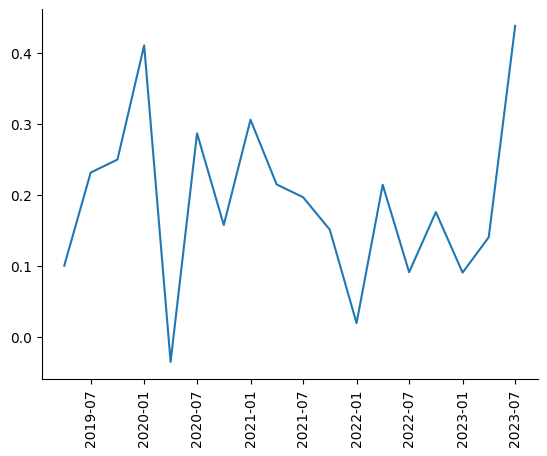

In [123]:
backtesting.plot_returns()

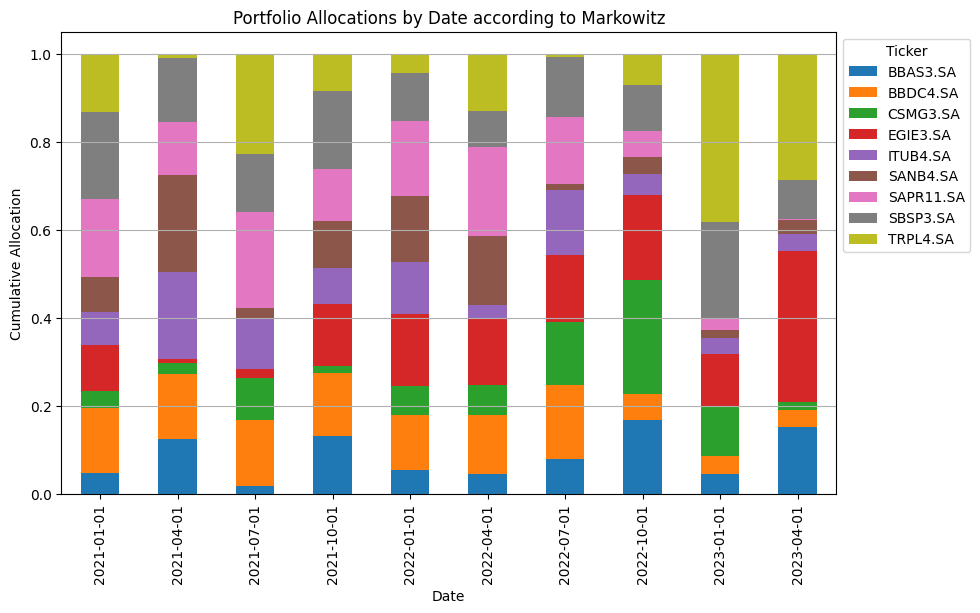

In [75]:
backtesting.plot_portfolio_over_time()

In [88]:
backtesting.data.loc[backtesting.rebalancing_dates[0] - timedelta(days=5): backtesting.rebalancing_dates[0] + timedelta(days=5)]

BBAS3.SA   BBDC4.SA   CSMG3.SA   EGIE3.SA   ITUB4.SA   SANB4.SA   
Date                                                                           
2020-12-28  32.429810  20.035807  13.839203  37.145210  29.081949  19.921694  \
2020-12-29  32.240253  20.003298  13.864412  36.855274  29.018658  19.830462   
2020-12-30  31.976528  19.719925  13.780386  36.399658  28.593779  19.482126   
2021-01-04  30.979328  19.204046  13.721565  36.101433  27.947107  19.407480   
2021-01-05  30.657917  19.086956  13.511501  35.778358  27.766220  18.918146   
2021-01-06  31.358429  19.719555  13.494695  35.488422  28.580208  19.598238   

            SAPR11.SA   SBSP3.SA   TRPL4.SA  
Date                                         
2020-12-28  22.917421  43.135887  23.158205  
2020-12-29  22.680319  42.220512  23.472607  
2020-12-30  21.396679  41.937401  23.009277  
2021-01-04  21.078608  40.163280  22.951361  
2021-01-05  20.245462  40.068909  22.802433  
2021-01-06  19.995516  39.870735  22.661779

## Pendências
1. Lidar com NaNs no backtesting